In [1]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 325)

# Final report <hr> <p style='font-size:15px'>by <i>purple teletubbies</i></p>

## Introduction
<div style="text-align: justify">
Drug development is generally arduous, costly, and the success rate is dauntingly low. Thus, the identification of drug-target interactions (DTIs) has become a crucial step in early stages of drug discovery. Experimental confirmation of new DTIs is not an easy task, as in vitro experiments are laborious and time-consuming. Even if a confirmed DTI has been used for developing a new drug, the approval for human use of such new drugs can take many years and estimated cost may run over a billion US dollars (Dimasi et al., 2003). Hence, we developed a deep learning model to predict the $pK_{d}$ of drug-target pair to make a fast scan through currently approved drugs to combat nCoV-19. Validating the readily available and approved drugs is more practical to curb the harsh situation in the meantime of waiting for development of de novo drugs.
</div>
<br>
<center>$K_{d}$ is the equilibrium dissociative constant, the lower the value, the higher the binding affinity, <br>
while $pK_{d}$ is calculated as:</center>
$$pK_{d} = -log_{10} K_{d}$$

## Method

### <u>Feature representation</u>

<div style="text-align: justify">
As there is no one with domain knowledge in our team, we opt for the simple way which no advanced feature engineering with domain knowledge is needed. Only the SMILES(Simplified Molecular Input Line Entry System) of ligands and protein chain sequence of targets are used as the features for our model. $Word2Vec$ embedding method is used to vectorize both the SMILES and protein chain sequence into vectors of size 100 each.
<br><br>
For SMILES, we use $SMILESVec$ to implement the word2vec method by splitting each SMILES into words with size $8$ as shown in the figure below, the size is chosen as recent study shows that most of the maximum common substructure(MCS) in drugs is between 8 and 12 (see ./mypackages/smilesvec.py for implementation details). It is trained on 2650000++ SMILES collected from ChemBL and BindingDB. After that, a vector of size 107 about the properties of a ligand is also contructed using $RDKit Descriptors$ (see ./mypackages/deepchem.py).<br>
   
<img src="https://raw.githubusercontent.com/Namewie180044/fch-drug-discovery/master/figure/smilesvec_example.png">
<br><br>
For protein chain sequence, we use $protvec$ by importing $biovec$ module (see protvec_training.ipynb for traning details). Protvec implementation is quite similar to smilesvec except that it uses word of length 3. It is trained on 560000++ fasta entries from swissprot. Later, the three vectors are concatenated into a single vector. Thereby, our model take in an input of vector of size 307. The input data is scaled using standard scaler before fitting it to our model.
</div>

This is our remaining data after feature engineering and dropping unwanted features.

In [2]:
bindingdb = pickle.load(open('data/dtba_prediction/featured_bindingdb', 'rb'))
bindingdb.head()

,id,ligand_smiles,target_name,Ki,Ki_r,IC50,IC50_r,Kd_r,Kd,EC50,EC50_r,pH,temp,molwt,pv_1,pv_2,pv_3,pv_4,pv_5,pv_6,pv_7,pv_8,pv_9,pv_10,pv_11,pv_12,pv_13,pv_14,pv_15,pv_16,pv_17,pv_18,pv_19,pv_20,pv_21,pv_22,pv_23,pv_24,pv_25,pv_26,pv_27,pv_28,pv_29,pv_30,pv_31,pv_32,pv_33,pv_34,pv_35,pv_36,pv_37,pv_38,pv_39,pv_40,pv_41,pv_42,pv_43,pv_44,pv_45,pv_46,pv_47,pv_48,pv_49,pv_50,pv_51,pv_52,pv_53,pv_54,pv_55,pv_56,pv_57,pv_58,pv_59,pv_60,pv_61,pv_62,pv_63,pv_64,pv_65,pv_66,pv_67,pv_68,pv_69,pv_70,pv_71,pv_72,pv_73,pv_74,pv_75,pv_76,pv_77,pv_78,pv_79,pv_80,pv_81,pv_82,pv_83,pv_84,pv_85,pv_86,pv_87,pv_88,pv_89,pv_90,pv_91,pv_92,pv_93,pv_94,pv_95,pv_96,pv_97,pv_98,pv_99,pv_100,sv_1,sv_2,sv_3,sv_4,sv_5,sv_6,sv_7,sv_8,sv_9,sv_10,sv_11,sv_12,sv_13,sv_14,sv_15,sv_16,sv_17,sv_18,sv_19,sv_20,sv_21,sv_22,sv_23,sv_24,sv_25,sv_26,sv_27,sv_28,sv_29,sv_30,sv_31,sv_32,sv_33,sv_34,sv_35,sv_36,sv_37,sv_38,sv_39,sv_40,sv_41,sv_42,sv_43,sv_44,sv_45,sv_46,sv_47,sv_48,sv_49,sv_50,sv_51,sv_52,sv_53,sv_54,sv_55,sv_56,sv_57,sv_58,sv_59,sv_60,sv_61,sv_62,sv_63,sv_64,sv_65,sv_66,sv_67,sv_68,sv_69,sv_70,sv_71,sv_72,sv_73,sv_74,sv_75,sv_76,sv_77,sv_78,sv_79,sv_80,sv_81,sv_82,sv_83,sv_84,sv_85,sv_86,sv_87,sv_88,sv_89,sv_90,sv_91,sv_92,sv_93,sv_94,sv_95,sv_96,sv_97,sv_98,sv_99,sv_100,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,dc_16,dc_17,dc_18,dc_19,dc_20,dc_21,dc_22,dc_23,dc_24,dc_25,dc_26,dc_27,dc_28,dc_29,dc_30,dc_31,dc_32,dc_33,dc_34,dc_35,dc_36,dc_37,dc_38,dc_39,dc_40,dc_41,dc_42,dc_43,dc_44,dc_45,dc_46,dc_47,dc_48,dc_49,dc_50,dc_51,dc_52,dc_53,dc_54,dc_55,dc_56,dc_57,dc_58,dc_59,dc_60,dc_61,dc_62,dc_63,dc_64,dc_65,dc_66,dc_67,dc_68,dc_69,dc_70,dc_71,dc_72,dc_73,dc_74,dc_75,dc_76,dc_77,dc_78,dc_79,dc_80,dc_81,dc_82,dc_83,dc_84,dc_85,dc_86,dc_87,dc_88,dc_89,dc_90,dc_91,dc_92,dc_93,dc_94,dc_95,dc_96,dc_97,dc_98,dc_99,dc_100,dc_101,dc_102,dc_103,dc_104,dc_105,dc_106,dc_107,dc_108,dc_109,dc_110,dc_111
0,1,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,HIV-1 Protease,0.24,0,NaN,0,0,NaN,NaN,0,5.5,37.0,475.25,-12.365314,-8.059343,-1.466848,-0.820672,-6.939306,-10.748078,-4.170938,-3.45643,4.829879,-21.11833,2.567362,-12.259262,-2.935864,-0.452478,12.367278,17.600216,-12.426291,6.178712,0.189721,-13.582825,11.279273,-3.461116,11.508619,-14.591913,-4.525795,2.050819,13.972644,-0.142365,6.438093,1.738649,-4.102619,-22.521111,2.615525,11.611776,-3.524966,7.436331,8.417536,0.840225,4.172556,13.876989,-7.828402,5.536438,-6.249434,-4.221833,11.07686,-6.120354,4.874056,9.107033,-10.163392,-10.182342,-20.171154,-7.311185,-8.945717,23.906462,-4.249462,1.05178,14.86973,4.157806,-14.753428,17.007236,-3.25788,-9.013313,-8.898209,11.23457,1.451483,4.613723,6.900777,-1.438853,-12.388937,16.581902,-6.256364,-0.427655,-13.187557,-3.678493,-7.879209,-7.010134,-18.409128,5.658381,-5.343101,-11.869392,-12.007268,12.615641,-3.835604,5.928756,-11.197845,-0.377606,-6.595539,-12.301859,0.615206,-6.25824,4.24475,2.408897,10.980761,1.763305,11.3034,-2.081758,-1.016971,1.10648,-2.972988,-15.030466,-11.283811,2.557599,3.643901,1.231730,10.628792,-2.213636,-1.676826,2.251702,0.277818,-2.322391,2.926505,11.713250,-3.485082,16.225645,-1.316037,-6.195838,-8.702117,-3.921040,19.834160,12.842640,0.405306,-0.950524,2.148253,6.038494,2.480601,-3.047265,9.666776,8.763798,-22.085663,5.941692,-9.985154,1.058916,6.987020,10.481554,15.169494,-7.136777,-8.942364,-18.260017,11.553541,-14.917837,2.331198,9.379317,2.990928,-8.773680,-17.686558,1.490206,-14.155701,5.113283,-13.478580,16.224003,-0.426115,-15.944901,7.559490,17.806479,2.975860,-7.619801,-10.203423,30.718569,-0.777498,13.696411,-8.822991,3.077476,11.064754,-15.013617,10.731857,-9.001007,-0.705863,-5.234287,0.440909,-3.865545,-4.964263,-1.932230,6.865426,-4.295790,-16.009195,-6.887674,8.213378,18.600616,-1.085864,7.558745,4.143389,-13.709464,-7.894740,1.819698,17.801682,-1.579828,-4.845886,19.113810,4.604551,-0.534830,3.381351,4.452736,7.881664,5.204886,-8.790221,-14.419156,1.393226,17.475985,-5.918790,5.757397

### <u>Model training</u>

In [3]:
class purple_teletubbies(nn.Module):
    def __init__(self):
        super(purple_teletubbies, self).__init__()
        self.fc1 = nn.Linear(307, 400)
        self.bn1 = nn.BatchNorm1d(400)
        self.fc2 = nn.Linear(707, 300)
        self.bn2 = nn.BatchNorm1d(300)
        self.fc3 = nn.Linear(1007, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(1207, 1)
    
    def forward(self, x, is_train=False):
        x1 = self.bn1(F.relu(self.fc1(x)))
        if is_train:
            x1 = F.dropout(x1, 0.3)
        x2 = self.bn2(F.relu(self.fc2(torch.cat([x, x1], 1))))
        if is_train:
            x2 = F.dropout(x2, 0.3)
        x3 = self.bn3(F.relu(self.fc3(torch.cat([x, x1, x2], 1))))
        if is_train:
            x3 = F.dropout(x3, 0.3)
        x4 = self.fc4(torch.cat([x, x1, x2, x3], 1))
        return x4

<div style="text-align: justify">
We use a fully connected network with dropout and batchnorm as our regressor model. The optimizer we use is Adam while the activation function is ReLU. It is trained with learning rate of 0.0007 and batch size 512. The maximum epoch is 400 with early stopping after 20 epoches without improvement on validation loss. The model is evaluated using MSELoss. In the end, it has test loss of 0.7995. (see model_training.ipynb for more details, all the random states are seeded in order to get reproducible results). The training process loss is depicted in the figure below.
<div>

![MSELoss](https://raw.githubusercontent.com/Namewie180044/fch-drug-discovery/master/figure/mseloss.jpeg)

## Dataset

In [4]:
bindingdb.shape

(1811727, 325)

In [5]:
(~bindingdb.Kd.isnull()).sum()

63610

<div style="text-align: justify">
We use drug-target binding affinity data from $bindingdb$. Out of more than 1.8 million data, we have only 63610 entries with $K_{d}$ not null. We convert it into $pK_{d}$ to make the data distribution more normal. However, there is one $pK_{d}$ value which comprises more than half of the dataset. After further investigation, those values are not exact in the original dataset, that is, they have > (larger than) or < (smaller than) symbol in the values. The $"Kd_r"$ column is engineered to indicate these uncertained values. We remove those values to avoid building a biased model and to build a more accurate regressor. After removing those values, the distribution is more normal, as shown below.
</div>

Text(0.5, 0, 'pKd (after dropping uncertained values)')

<Figure size 432x288 with 0 Axes>

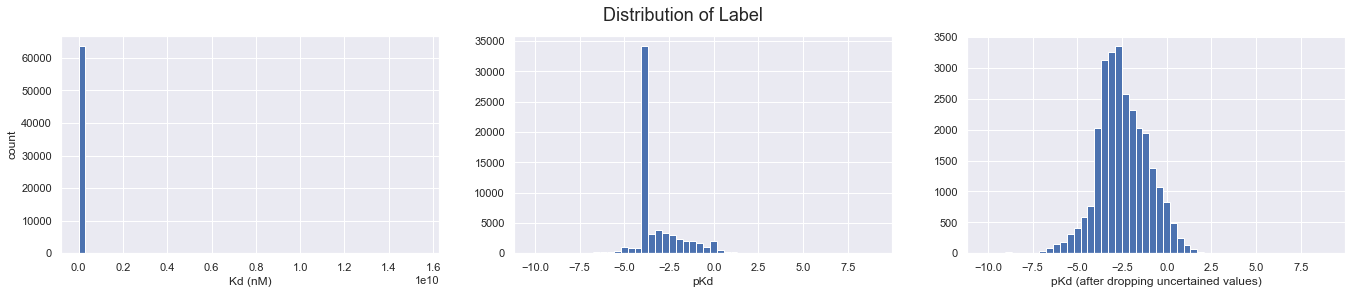

In [6]:
feature = 'Kd'

bindingdb.dropna(subset=[feature], inplace=True)
bindingdb.drop_duplicates(inplace=True)

plt.tight_layout()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(23)
fig.suptitle('Distribution of Label', fontsize=18)
ax1.hist(bindingdb[feature], bins=50)
ax1.set_ylabel('count')
ax1.set_xlabel('Kd (nM)')

bindingdb.loc[bindingdb[feature]==0, feature] = 1e-9
bindingdb[feature] = -np.log10(bindingdb[feature])
ax2.hist(bindingdb[feature], bins=50)
ax2.set_xlabel('pKd')

bindingdb = bindingdb[bindingdb[feature+'_r'] == 0]

ax3.hist(bindingdb[feature], bins=50)
ax3.set_xlabel('pKd (after dropping uncertained values)')

## Results

<div style="text-align: justify">
After training our model, we use it to scan the FDA approved drugs from DrugBank and DrugCentral against nCoV-19 main protease (see ./approved_drugs_validation.ipynb). Drugs with top predicted values are checked with pyrx to confirm the results, and the top drugs are reordered based on their binding affinity from pyrx. As the time is limited, we only checked the combined top twenty drugs from the two databases. The top ten drugs are listed below.
</div>

In [7]:
results = pd.read_csv('data/dtba_prediction/final_checked_result.csv')[['Name', 'Binding Affinity (kcal/mol)']]
results.index = np.arange(1, 11)

In [8]:
results

,Name,Binding Affinity (kcal/mol)
1,nafamostat,-8.0
2,cimetropium,-6.9
3,Inositol nicotinate,-5.8
4,Podophyllin,-5.7
5,asunaprevir,-5.6
6,Sorbinicate,-5.0
7,isavuconazonium,-4.9
8,betacarotene,-4.4
9,grazoprevir,-4.1
10,Voxilaprevir,-3.9


## Conclusion

<div style="text-align: justify">
We developed a machine learning model to predict the $pK_{d}$ of drug-target binding without complicated feature engineering, only SMILES of ligands and protein sequence of targets have to be known in order to make prediction. Not only the model can be applied in this case, it can be applied for any de novo drugs or new virus in the future. The model can do scanning through a database very quickly. Here, however, we only scanned two database, more can be done, but the bottleneck exists at using virtual docking software to affirm the values, many time is taken for a just single drug.
</div>

## Final thought <span style='font-size:16px'> - what can be done better</span>

<div style="text-align: justify">
Frankly speaking, mseloss of 0.7995 on train set still leaves a lot to be desired. Better feature representation could be used which we don't have time to do so. SMILESVec should be trained with more SMILES as 2 millions is too less to represent the whole diversity. At our stage, after each online training of word2vec(SMILESVec) by encountering new vocabs(which we face a lot), the model have to be retrained. The SMILESVec which cannont represent the whole diversity cannot give accurate representation of SMILES.
</div>